### Part 1 - Setup and Baseline

##### Download and load the data

In [1]:
import os
import pickle
import numpy as np

# Download if doesn't already exist
if not os.path.exists('cifar-10-batches-py'):
    os.system('wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    os.system('tar -xvf cifar-10-python.tar.gz')
    os.system('rm cifar-10-python.tar.gz')

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X_train = []
Y_train = []

# Load all the data
for i in range(1, 6):
    batch = unpickle(f'cifar-10-batches-py/data_batch_{i}')
    X_train.append(batch[b'data'])
    Y_train.append(batch[b'labels'])

X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)

# Load the test data
batch = unpickle('cifar-10-batches-py/test_batch')
X_test = batch[b'data']
Y_test = np.array(batch[b'labels'])

# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

# Generate random 10% indices
np.random.seed(0)
train_indices = np.random.choice(X_train.shape[0], X_train.shape[0] // 10, replace=False)
test_indices = np.random.choice(X_test.shape[0], X_test.shape[0] // 10, replace=False)

# Get the 10% normalized data
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

4


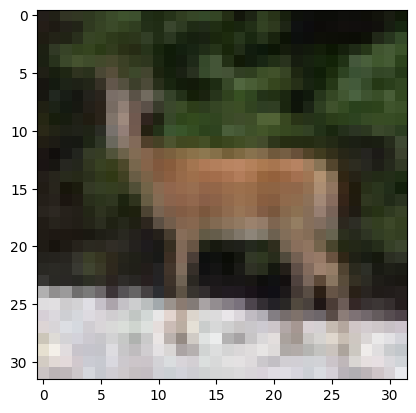

In [2]:
# Show the first image

import matplotlib.pyplot as plt
plt.imshow(X_train[5].reshape(3, 32, 32).transpose(1, 2, 0))
print(Y_train[5])

##### Establish SVM baseline

In [109]:
from sklearn.svm import SVC

# Linear SVM
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)
test_acc = clf.score(X_test, Y_test)
print(f'Linear SVM Train Accuracy: {test_acc}')

# RBF SVM
clf = SVC(kernel='rbf')
clf.fit(X_train, Y_train)
test_acc = clf.score(X_test, Y_test)
print(f'RBF SVM Train Accuracy: {test_acc}')

In [2]:
import torch
X_train = torch.tensor(X_train, dtype=torch.float32, device="cpu")
Y_train = torch.tensor(Y_train, dtype=torch.long, device="cpu")
X_test = torch.tensor(X_test, dtype=torch.float32, device="cpu")
Y_test = torch.tensor(Y_test, dtype=torch.long, device="cpu")

### Part 2 - Feed Forward Neural Network

1. Baseline

In [3]:
import torch
from torch import nn

INPUT_DIM = 32*32*3
OUTPUT_DIM = 10

class FFN(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=256, output_dim=OUTPUT_DIM, init_std=1.0, xavier=False, depth=2, decay_and_dropout=False):
        super(FFN, self).__init__()
        self.first_layer = nn.Linear(input_dim, hidden_dim)

        self.middle_layers = [nn.Linear(hidden_dim, hidden_dim) for _ in range(depth-2)]

        self.last_layer = nn.Linear(hidden_dim, output_dim)

        if xavier:
            nn.init.xavier_normal_(self.first_layer.weight)
            nn.init.xavier_normal_(self.last_layer.weight)

            for layer in self.middle_layers:
                nn.init.xavier_normal_(layer.weight)
                # nn.init.xavier_normal_(layer.bias)

            # nn.init.xavier_normal_(self.layer1.bias)
            # nn.init.xavier_normal_(self.layer2.bias)
        else:
            self.first_layer.weight.data.normal_(mean=0.0, std=init_std)
            self.first_layer.bias.data.normal_(mean=0.0, std=init_std)
            self.last_layer.weight.data.normal_(mean=0.0, std=init_std)
            self.last_layer.bias.data.normal_(mean=0.0, std=init_std)

            for layer in self.middle_layers:
                layer.weight.data.normal_(mean=0.0, std=init_std)
                layer.bias.data.normal_(mean=0.0, std=init_std)

    def forward(self, x):
        x = self.first_layer(x)
        x = nn.functional.relu(x)

        for layer in self.middle_layers:
            x = layer(x)
            x = nn.functional.relu(x)

        x = self.last_layer(x)
        return x

In [4]:
from tqdm import tqdm
from sklearn.decomposition import PCA

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def pca_whiten(train_data, test_data, n_components):
    pca = PCA(n_components=n_components, whiten=True)
    train_transformed = pca.fit_transform(train_data)
    test_transformed = pca.transform(test_data)
    return train_transformed, test_transformed


def train(lr, momentum, init_std, batch_size=64, num_ep=100, device='cpu', adam_optim=False, xavier=False, pca_whitening=False, width=256, depth=2):
    m_X_train = X_train
    m_X_test = X_test

    input_dim = INPUT_DIM

    if pca_whitening:
        n_components = 1000
        m_X_train, m_X_test = pca_whiten(X_train.cpu().numpy(), X_test.cpu().numpy(), n_components)
        m_X_train = torch.tensor(m_X_train).float().to(device)
        m_X_test = torch.tensor(m_X_test).float().to(device)

        input_dim = 1000

    model = FFN(init_std=init_std, xavier=xavier, hidden_dim=width, depth=depth, input_dim=input_dim).to(device)

    criterion = nn.CrossEntropyLoss()

    if adam_optim:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    test_losses = []
    test_accuracies = []
    training_losses = []
    training_accuracies = []

    for _ in range(num_ep):

        # Shuffle the data
        indices = torch.randperm(m_X_train.shape[0])

        for i in range(0, m_X_train.shape[0], batch_size):
            optimizer.zero_grad()
            batch_xs = m_X_train[indices[i:i+batch_size]]
            batch_ys = Y_train[indices[i:i+batch_size]]

            outputs = model(batch_xs)
            loss = criterion(outputs, batch_ys)
            loss.backward()
            optimizer.step()

        model.eval()

        with torch.no_grad():
            test_loss = criterion(model(m_X_test), Y_test)
            test_acc = accuracy(model(m_X_test), Y_test)
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc.item())

            train_loss = criterion(model(m_X_train), Y_train)
            train_acc = accuracy(model(m_X_train), Y_train)
            training_losses.append(train_loss.item())
            training_accuracies.append(train_acc.item())

    return model, test_losses, test_accuracies, training_losses, training_accuracies


def grid_search_params(adam_optim=False):
    lrs = [0.01,0.001, 0.0001]
    momentums = [0.9, 0.95, 0.99]
    init_stds = [0.1, 0.5, 1.0]
    
    param_combinations = [(lr, mu, std) for lr in lrs for mu in momentums for std in init_stds]

    best_acc = 0
    best_params = None
    for lr, mu, std in tqdm(param_combinations):
        _, _, test_accuracies, _, _ = train(lr, mu, std, num_ep=100, device='cpu', adam_optim=adam_optim)
        acc = test_accuracies[-1]
        if acc > best_acc:
            best_acc = acc
            best_params = (lr, mu, std)

    return best_params, best_acc
    
# grid_search_params()

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Final Test Accuracy: 0.3889999985694885 and Loss: 1.885542869567871


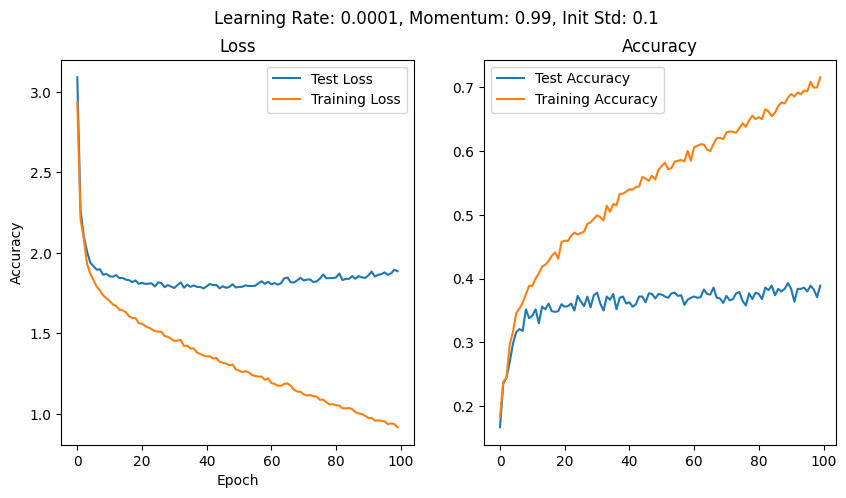

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, title):
    print(f"Final Test Accuracy: {test_accuracies[-1]} and Loss: {test_losses[-1]}")

    # Plot training and test losses
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(test_losses, label='Test Loss')
    ax[0].plot(training_losses, label='Training Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()


    # Plot training and test accuracies
    ax[1].plot(test_accuracies, label='Test Accuracy')
    ax[1].plot(training_accuracies, label='Training Accuracy')
    ax[1].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[1].legend()

    # Add title to the plot
    plt.suptitle(title)

    plt.show()

lr, mu, std = (0.0001, 0.99, 0.1)
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='cpu')
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, f'Learning Rate: {lr}, Momentum: {mu}, Init Std: {std}')


2. Optimization

Final Test Accuracy: 0.36899998784065247 and Loss: 1.9363081455230713


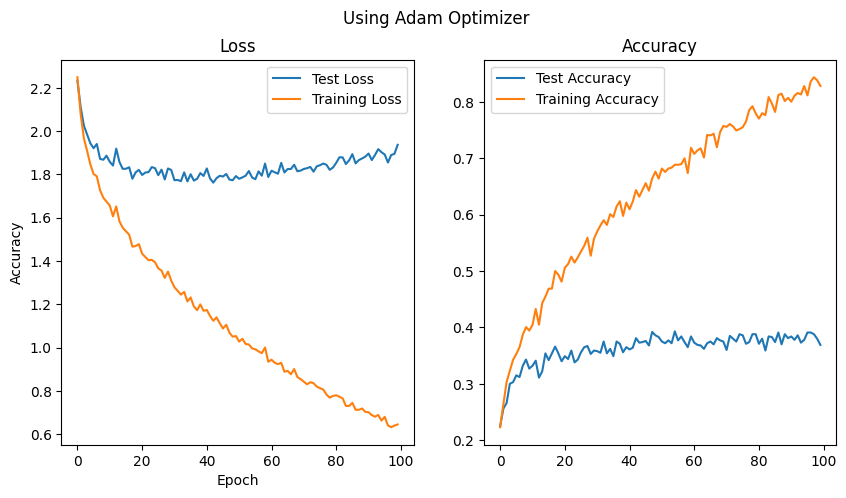

In [6]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='cpu', adam_optim=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using Adam Optimizer")

3. Initialization

Final Test Accuracy: 0.38600000739097595 and Loss: 1.7539737224578857


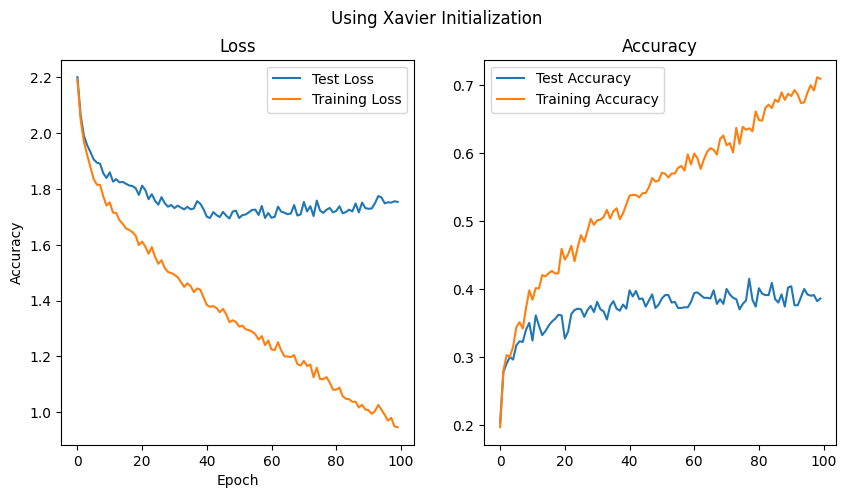

In [7]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='cpu', xavier=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using Xavier Initialization")

4. Regularization

5. Preprocessing

Final Test Accuracy: 0.22300000488758087 and Loss: 4.763021469116211


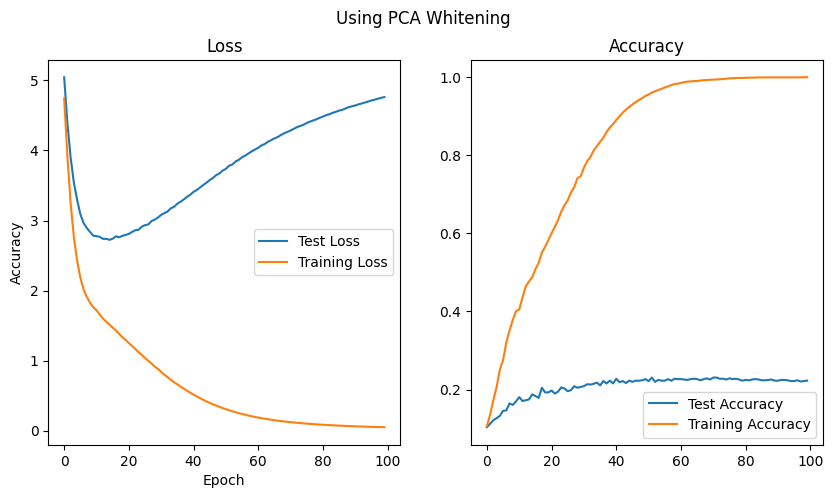

In [8]:
model, test_losses, test_accuracies, training_losses, training_accuracies = train(lr, mu, std, num_ep=100, device='cpu', pca_whitening=True)
plot_graphs(test_losses, test_accuracies, training_losses, training_accuracies, "Using PCA Whitening")

6. Network Width

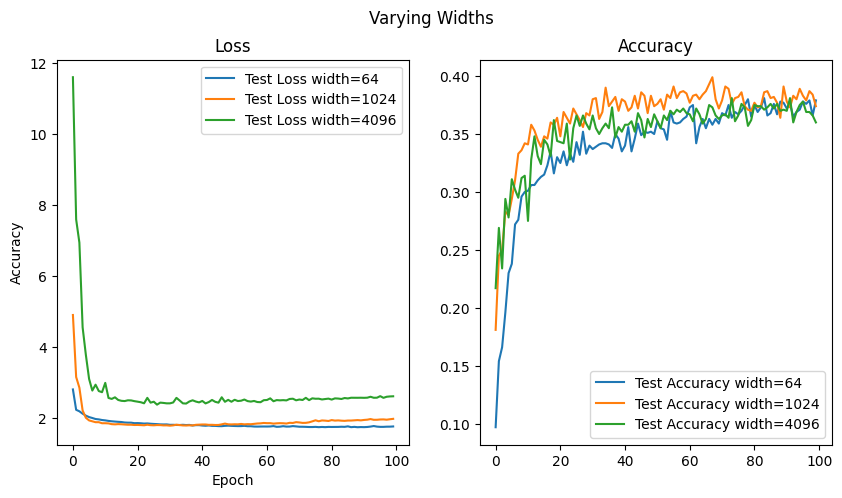

In [9]:
model1, test_losses1, test_accuracies1, training_losses1, training_accuracies1 = train(lr, mu, std, num_ep=100, device='cpu', width=2**6)
model2, test_losses2, test_accuracies2, training_losses2, training_accuracies2 = train(lr, mu, std, num_ep=100, device='cpu', width=2**10)
model3, test_losses3, test_accuracies3, training_losses3, training_accuracies3 = train(lr, mu, std, num_ep=100, device='cpu', width=2**12)

# Plot training and test losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(test_losses1, label=f'Test Loss width={2**6}')
ax[0].plot(test_losses2, label=f'Test Loss width={2**10}')
ax[0].plot(test_losses3, label=f'Test Loss width={2**12}')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and test accuracies
ax[1].plot(test_accuracies1, label=f'Test Accuracy width={2**6}')
ax[1].plot(test_accuracies2, label=f'Test Accuracy width={2**10}')
ax[1].plot(test_accuracies3, label=f'Test Accuracy width={2**12}')
ax[1].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].legend()

# Add title to the plot
plt.suptitle('Varying Widths')
plt.show()

7. Network Depth

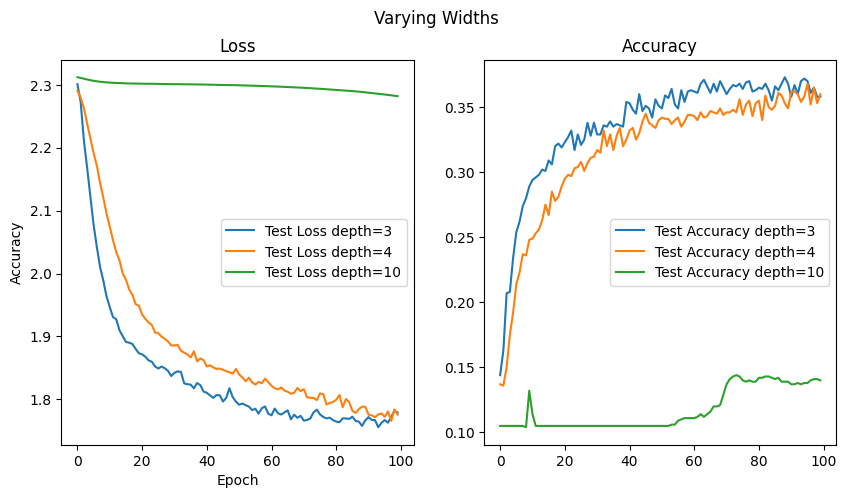

In [10]:
model1, test_losses1, test_accuracies1, training_losses1, training_accuracies1 = train(lr, mu, std, num_ep=100, device='cpu', width=64, depth=3)
model2, test_losses2, test_accuracies2, training_losses2, training_accuracies2 = train(lr, mu, std, num_ep=100, device='cpu', width=64, depth=4)
model3, test_losses3, test_accuracies3, training_losses3, training_accuracies3 = train(lr, mu, std, num_ep=100, device='cpu', width=64, depth=10)

# Plot training and test losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(test_losses1, label=f'Test Loss depth=3')
ax[0].plot(test_losses2, label=f'Test Loss depth=4')
ax[0].plot(test_losses3, label=f'Test Loss depth=10')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and test accuracies
ax[1].plot(test_accuracies1, label=f'Test Accuracy depth=3')
ax[1].plot(test_accuracies2, label=f'Test Accuracy depth=4')
ax[1].plot(test_accuracies3, label=f'Test Accuracy depth=10')
ax[1].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].legend()

# Add title to the plot
plt.suptitle('Varying Widths')
plt.show()